In [5]:
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, precision_recall_curve, auc,
                           roc_curve)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import entropy

In [8]:
import warnings
warnings.filterwarnings('ignore')


In [9]:
# Set random seed (using last 4 digits of student ID)
RANDOM_SEED = 5117
np.random.seed(RANDOM_SEED)


In [10]:
# Set style for visualizations
sns.set_style("whitegrid")
plt.style.use('ggplot')

In [11]:
# Set probability threshold for PASS classification
PASS_THRESHOLD = 0.4  # Clients with probabilities between 0.4-0.6 will be classified as PASS


### 加载数据函数

In [12]:
def load_data(filepath):
    """Load and preprocess the data with proper handling of missing values"""
    df = pd.read_csv(filepath, na_values=['.', ' ', ''])
    df = df.dropna(how='all')
    
    # Create target variable with three classes (GOOD=1, BAD=0, PASS=0.5)
    df['target'] = np.where(df['GOOD'] == 1, 2, 
                           np.where(df['BAD'] == 1, 0, 1))
    
    return df


### 数据清洗函数

In [13]:
def clean_data(df):
    """Clean and preprocess the data with proper encoding of categorical variables"""
    numeric_cols = ['cust_age', 'time_emp', 'disp_income', 'S_01', 'S_02', 
                   'CA_02', 'CA_03', 'ER_01', 'ER_02', 'P_01']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if col == 'time_emp':
                df[col] = np.where(df[col] > 100, np.nan, df[col])
    
    cat_cols = ['occ_code', 'res_indicator', 'CA_01']
    label_encoders = {}
    
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown').astype(str)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    
    if 'CA_01' in df.columns:
        df['CA_01'] = pd.to_numeric(df['CA_01'], errors='coerce')
        df['CA_01'] = df['CA_01'].fillna(0).astype(int)
    
    return df


### 特征工程函数

In [14]:
def feature_engineering(df):
    """Create meaningful features for credit default prediction"""
    if 'disp_income' in df.columns and 'cust_age' in df.columns:
        df['income_to_age_ratio'] = df['disp_income'] / (df['cust_age'].replace(0, 1) + 1)
    
    if 'time_emp' in df.columns and 'cust_age' in df.columns:
        df['employment_ratio'] = df['time_emp'] / (df['cust_age'] - 18 + 1)
    
    df['age_group'] = pd.cut(df['cust_age'], 
                           bins=[0, 25, 35, 45, 55, 100],
                           labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    if 'disp_income' in df.columns:
        try:
            df['income_group'] = pd.qcut(df['disp_income'], q=5, duplicates='drop',
                                      labels=['very_low', 'low', 'medium', 'high', 'very_high'])
        except:
            df['income_group'] = pd.cut(df['disp_income'], bins=5,
                                      labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    
    df = df.replace([np.inf, -np.inf], np.nan)
    return df


### 数据准备函数

In [15]:
def prepare_data(df):
    """Prepare data for modeling with proper validation checks"""
    if len(df) == 0:
        raise ValueError("No samples with target values after preprocessing.")
    
    drop_cols = ['app_id', 'GOOD', 'BAD', 'target', 'app_date']
    X = df.drop([col for col in drop_cols if col in df.columns], axis=1)
    y = df['target']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)
    
    return X_train, X_test, y_train, y_test


### 构建预处理管道

In [16]:
def build_preprocessor():
    """Build preprocessing pipeline"""
    numeric_features = ['cust_age', 'time_emp', 'disp_income', 
                       'S_01', 'S_02', 'CA_02', 'CA_03', 
                       'ER_01', 'ER_02', 'P_01',
                       'income_to_age_ratio', 'employment_ratio']
    
    categorical_features = ['occ_code', 'res_indicator', 'CA_01', 
                           'age_group', 'income_group']
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return preprocessor


### 置信度计算函数

In [17]:
def calculate_confidence(predictions):
    """Calculate confidence scores based on prediction probabilities"""
    # Confidence is 1 - normalized entropy of the probability distribution
    confidences = []
    for prob in predictions:
        if len(prob) == 2:  # Binary case
            ent = entropy([prob[0], prob[1]])
            max_ent = np.log(2)  # Maximum entropy for binary distribution
        else:  # Multiclass case
            ent = entropy(prob)
            max_ent = np.log(len(prob))  # Maximum entropy for n-class distribution
        normalized_ent = ent / max_ent
        confidence = 1 - normalized_ent
        confidences.append(confidence)
    return np.array(confidences)


阈值调优

In [18]:
### 阈值调优函数
def optimize_threshold(model, X_test, y_test, metric='roc_auc'):
    """Optimize the PASS_THRESHOLD based on the chosen metric"""
    # Get probabilities for GOOD class (class 2)
    y_proba_good = model.predict_proba(X_test)[:, 2]

    # Filter out PASS cases (class 1) for binary evaluation
    binary_mask = y_test != 1
    y_test_binary = y_test[binary_mask]
    y_proba_good_filtered = y_proba_good[binary_mask]

    # Map GOOD (2) to 1 for binary evaluation
    y_test_binary = np.where(y_test_binary == 2, 1, y_test_binary)

    # Test different thresholds
    thresholds = np.linspace(0.1, 0.5, 50)  # Test thresholds from 0.1 to 0.5
    best_metric = -1
    best_threshold = 0.4  # Default

    for threshold in thresholds:
        # Binary predictions based on threshold
        y_pred_binary = np.where(y_proba_good_filtered > 0.5 + threshold/2, 1, 
                                np.where(y_proba_good_filtered < 0.5 - threshold/2, 0, -1))
        
        # Filter out PASS cases (-1)
        mask = y_pred_binary != -1
        y_pred_filtered = y_pred_binary[mask]
        y_true_filtered = y_test_binary[mask]

        if len(np.unique(y_true_filtered)) < 2:
            continue  # Skip if only one class present

        if metric == 'f1':
            current_metric = f1_score(y_true_filtered, y_pred_filtered)
        elif metric == 'roc_auc':
            current_metric = roc_auc_score(y_true_filtered, y_pred_filtered)
        elif metric == 'custom':
            # Custom metric: balance between F1 and PASS rate
            pass_rate = np.mean(y_pred_binary == -1)
            current_metric = f1_score(y_true_filtered, y_pred_filtered) * (1 - pass_rate)
        else:
            raise ValueError("Invalid metric. Choose 'f1', 'roc_auc', or 'custom'.")

        if current_metric > best_metric:
            best_metric = current_metric
            best_threshold = threshold

    print(f"\nOptimal threshold: {best_threshold:.3f} (best {metric}: {best_metric:.4f})")
    return best_threshold

### 模型评估函数

In [19]:
### 模型评估函数 (Updated proper 3-class version)
### 模型评估函数 (Fixed 3-class with threshold)

def evaluate_model(model, X_test, y_test, pass_threshold=0.2):
    """Comprehensive model evaluation with threshold-based PASS classification"""
    # Get probabilities for each class
    y_proba = model.predict_proba(X_test)
    
    
    pass_threshold = optimize_threshold (model,X_test, y_test)
    # Three-class predictions with threshold (GOOD=2, BAD=0, PASS=1)
    good_proba = y_proba[:, 2]
    bad_proba = y_proba[:, 0]
    
    y_pred = np.where(
        (good_proba - bad_proba) > pass_threshold, 2,  # GOOD
        np.where(
            (bad_proba - good_proba) > pass_threshold, 0,  # BAD
            1  # PASS (uncertain cases)
        )
    )
    
    # Calculate confidence scores
    confidences = calculate_confidence(y_proba)
    
    # Classification report for all three classes
    print("\nClassification Report (3-class with threshold):")
    print(classification_report(y_test, y_pred, 
                              target_names=['BAD', 'PASS', 'GOOD']))
    
    # Confusion Matrix for 3-class
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Predicted BAD', 'Predicted PASS', 'Predicted GOOD'],
               yticklabels=['Actual BAD', 'Actual PASS', 'Actual GOOD'])
    plt.title('Confusion Matrix (3-class)')
    plt.show()
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': model.named_steps['preprocessor'].get_feature_names_out(),
        'importance': model.named_steps['classifier'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', 
               data=feature_importance.head(20))
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.show()
    
    # Probability distribution plot
    plt.figure(figsize=(10, 6))
    sns.histplot(good_proba - bad_proba, bins=30, kde=True)
    plt.axvline(x=pass_threshold, color='r', linestyle='--', label='GOOD threshold')
    plt.axvline(x=-pass_threshold, color='r', linestyle='--', label='BAD threshold')
    plt.xlabel('Probability Difference (GOOD - BAD)')
    plt.ylabel('Count')
    plt.title('Decision Confidence Distribution')
    plt.legend()
    plt.show()
    
    # Create output dictionary
    results = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': cm,
        'feature_importance': feature_importance,
        'probabilities': y_proba,
        'predictions': y_pred,
        'confidences': confidences,
        'pass_threshold': pass_threshold,
        'pass_rate': np.mean(y_pred == 1)
    }
    
    print("\nPredicted Class Distribution:")
    print(f"BAD: {np.mean(y_pred == 0):.2%}")
    print(f"PASS: {results['pass_rate']:.2%}")
    print(f"GOOD: {np.mean(y_pred == 2):.2%}")
    
    return results

### 模型训练函数

In [20]:
def train_model(X_train, X_test, y_train, y_test, preprocessor):
    """Train and evaluate the model with 3-class classification"""
    # Convert target to integer (GOOD=2, BAD=0, PASS=1)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            random_state=RANDOM_SEED,
            class_weight='balanced',  # Handles class imbalance
            n_estimators=200,
            max_depth=12,
            min_samples_split=5
        ))
    ])
    
    # Train directly on all three classes
    pipeline.fit(X_train, y_train)
    
    # Evaluate the model
    results = evaluate_model(pipeline, X_test, y_test)
    
    return pipeline, results


### 数据可视化函数

In [21]:
def visualize_data(df):
    """Create exploratory data visualizations"""
    # Target distribution
    plt.figure(figsize=(8, 6))
    target_counts = df['target'].value_counts()
    sns.barplot(x=['BAD', 'PASS', 'GOOD'], y=[target_counts.get(0, 0), target_counts.get(1, 0), target_counts.get(2, 0)])
    plt.title('Distribution of Target Variable')
    
    plt.ylabel('Count')
    plt.show()
    
    # Age distribution by target
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='cust_age', hue='target', 
                 bins=30, kde=True, multiple='stack')
    plt.title('Age Distribution by Target')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.legend(['BAD', 'PASS', 'GOOD'])
    plt.show()
    
    # Income distribution
    if 'P_01' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y='P_01', data=df)
        plt.title('P_1 Distribution by Target')
        
        plt.yscale('linear')  # Log scale due to wide income range
        plt.show()
    
    # Employment duration
    if 'cust_age' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y='cust_age', data=df)
        plt.title('cust_age by Target')
        plt.yscale('linear')
        plt.show()
        
    if 'employment_ratio' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y='employment_ratio', data=df)
        plt.title('Employment_ratio Distribution by Target')
        plt.yscale('linear')  # Log scale due to wide income range
        plt.show()
    
    # Correlation matrix for numeric features
    numeric_cols = ['cust_age', 'time_emp', 'disp_income', 'S_01', 'S_02', 
                   'CA_02', 'CA_03', 'ER_01', 'ER_02', 'P_01', 'target']
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    plt.show()


### 主程序入口

In [22]:
def main():
    try:
        # 1. Load data
        print("Loading data...")
        df = load_data('P2data5117.csv')
        print(f"Initial data shape: {df.shape}")
        
        # 2. Clean data
        print("Cleaning data...")
        df_clean = clean_data(df)
        print(f"Data shape after cleaning: {df_clean.shape}")
        
        # 3. Feature engineering
        print("Performing feature engineering...")
        df_fe = feature_engineering(df_clean)
        df_fe.to_csv('data_cleaned.csv', index=False)
        print(f"Data shape after feature engineering: {df_fe.shape}")
        
        # 4. Data visualization
        print("Creating exploratory visualizations...")
        visualize_data(df_fe)
        
        # 5. Prepare modeling data
        print("Preparing data for modeling...")
        X_train, X_test, y_train, y_test = prepare_data(df_fe)
        print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
        
        # 6. Build preprocessing pipeline
        print("Building preprocessing pipeline...")
        preprocessor = build_preprocessor()
        
        # 7. Train and evaluate model
        print("Training and evaluating model...")
        model, results = train_model(X_train, X_test, y_train, y_test, preprocessor)
        
        print("\nFinal Recommendation:")
        print("Based on the evaluation metrics, we recommend deploying the Random Forest model with the following approach:")
        print("1. Three-class classification (GOOD, BAD, PASS) where:")
        print(f"   - GOOD if (P(GOOD) - P(BAD)) > {results['pass_threshold']:.2f}")
        print(f"   - BAD if (P(BAD) - P(GOOD)) > {results['pass_threshold']:.2f}")
        print(f"   - PASS otherwise (uncertain cases)")
        print(f"2. Current PASS rate: {results['pass_rate']:.2%} of cases need further review")
        print("\nModel performance across all classes:")
        print(f"- Accuracy: {results['classification_report']['accuracy']:.4f}")
        print(f"- GOOD Precision: {results['classification_report']['2']['precision']:.4f}")
        print(f"- GOOD Recall: {results['classification_report']['2']['recall']:.4f}")
        print(f"- BAD Precision: {results['classification_report']['0']['precision']:.4f}")
        print(f"- BAD Recall: {results['classification_report']['0']['recall']:.4f}")
        
        # Create a sample output dataframe with predictions and confidence
        sample_output = X_test.copy()
        sample_output['True_Label'] = y_test.map({0: 'BAD', 1: 'PASS', 2: 'GOOD'})
        sample_output['P(GOOD)'] = results['probabilities'][:, 2]
        sample_output['P(BAD)'] = results['probabilities'][:, 0]
        sample_output['P(PASS)'] = results['probabilities'][:, 1]
        sample_output['Predicted_Class'] = results['predictions']
        sample_output['Predicted_Class'] = sample_output['Predicted_Class'].map({0: 'BAD', 1: 'PASS', 2: 'GOOD'})
        sample_output['Confidence'] = results['confidences']
        
        print("\nSample predictions with confidence scores:")
        print(sample_output[['True_Label', 'P(GOOD)', 'P(BAD)', 'P(PASS)', 
                           'Predicted_Class', 'Confidence']].head(10))
                
        return model, results
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None, None

### 主程序入口

Loading data...
Initial data shape: (9289, 26)
Cleaning data...
Data shape after cleaning: (9289, 26)
Performing feature engineering...
Data shape after feature engineering: (9289, 30)
Creating exploratory visualizations...


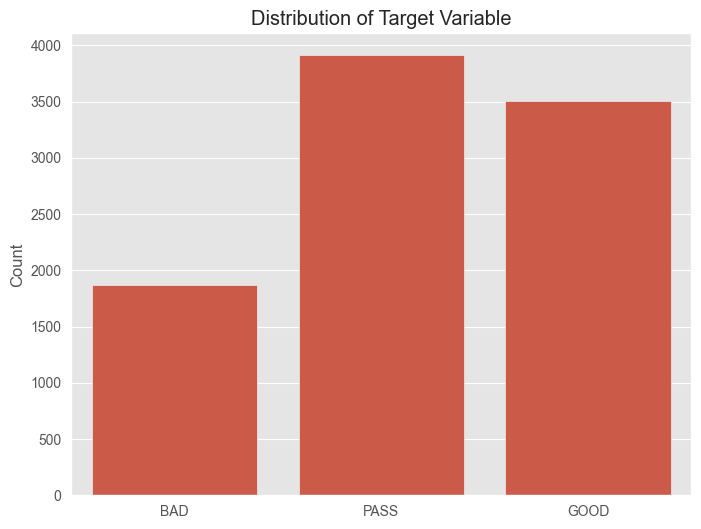

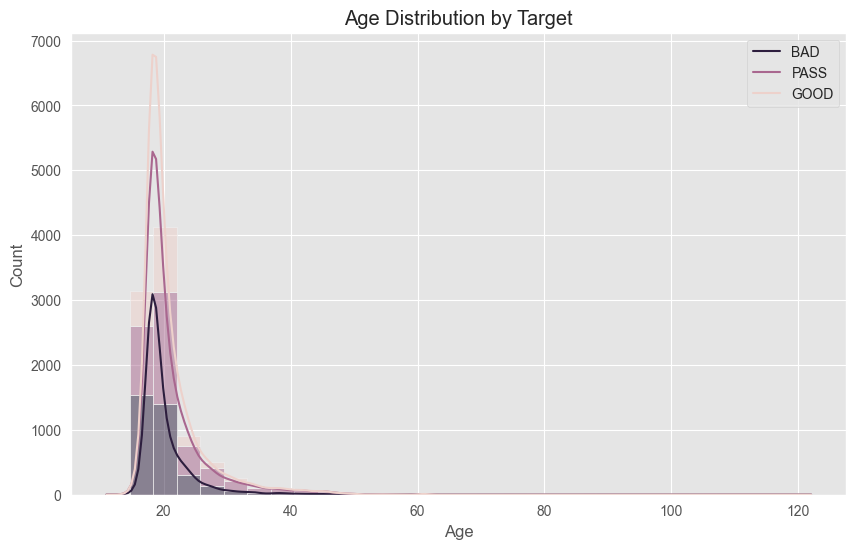

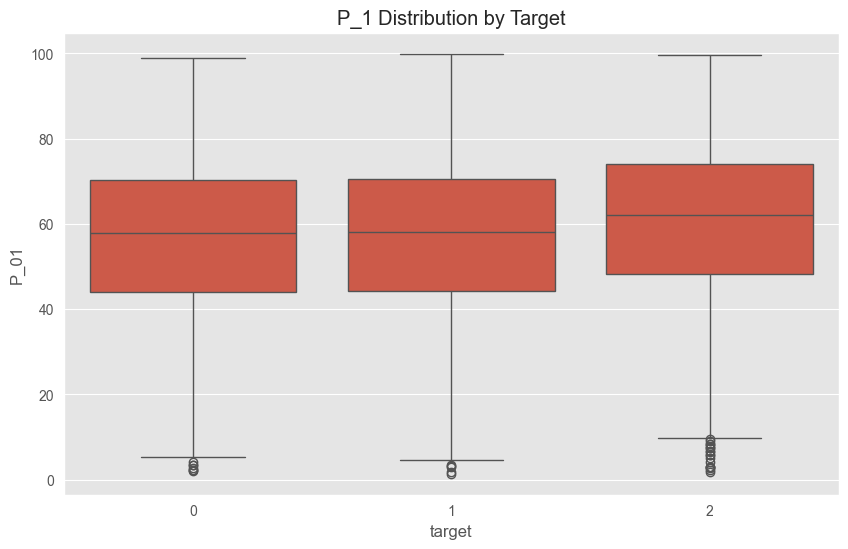

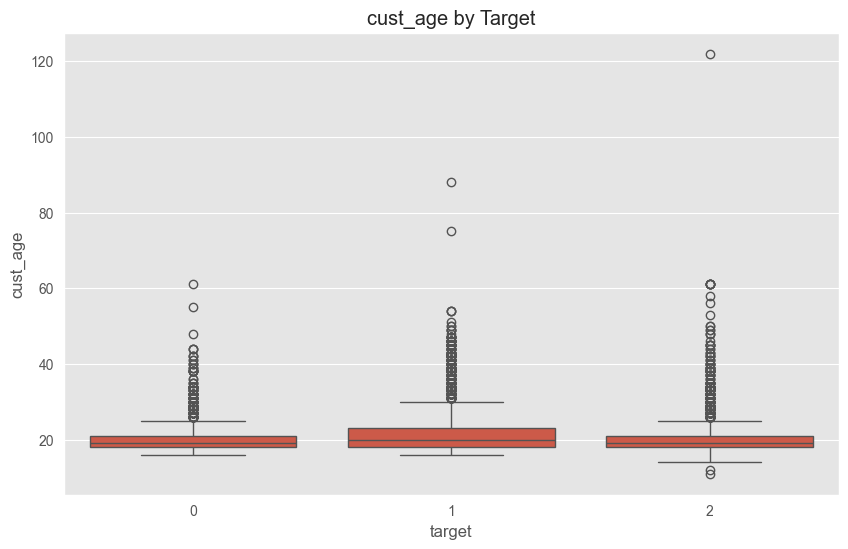

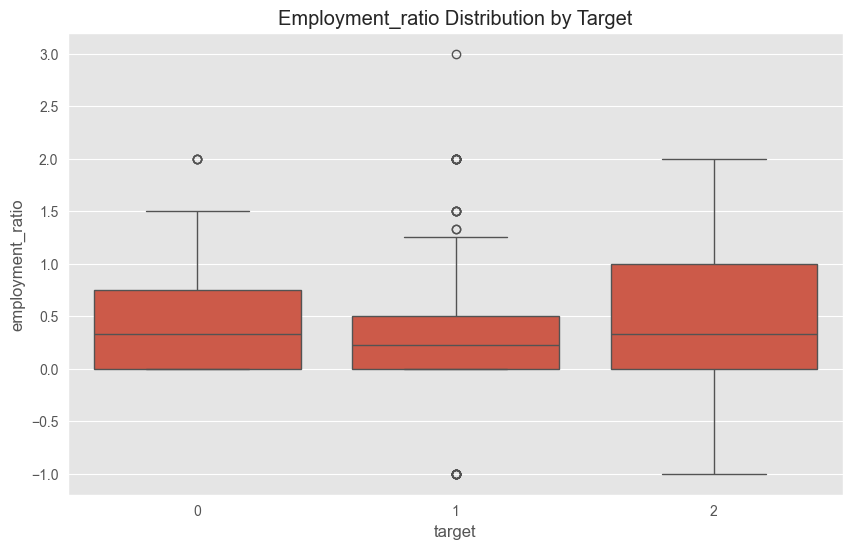

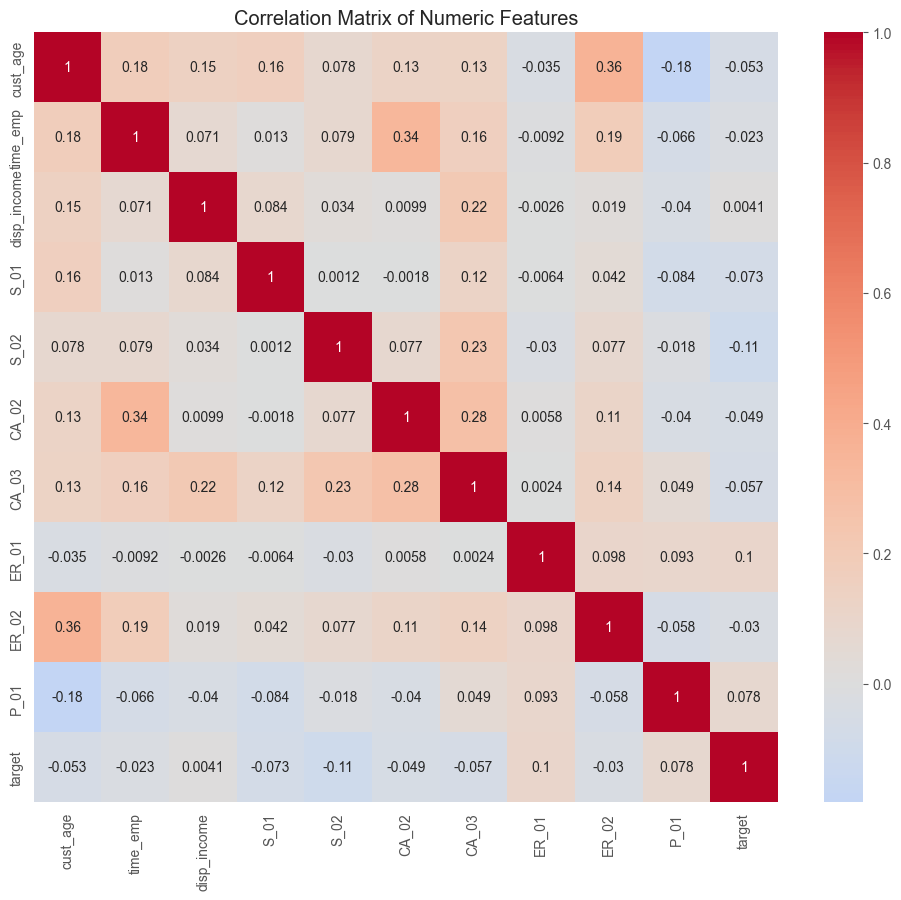

Preparing data for modeling...
Training samples: 6502, Test samples: 2787
Building preprocessing pipeline...
Training and evaluating model...

Optimal threshold: 0.100 (best roc_auc: 0.5586)

Classification Report (3-class with threshold):
              precision    recall  f1-score   support

         BAD       0.28      0.30      0.29       561
        PASS       0.46      0.48      0.47      1174
        GOOD       0.54      0.51      0.52      1052

    accuracy                           0.45      2787
   macro avg       0.43      0.43      0.43      2787
weighted avg       0.46      0.45      0.45      2787



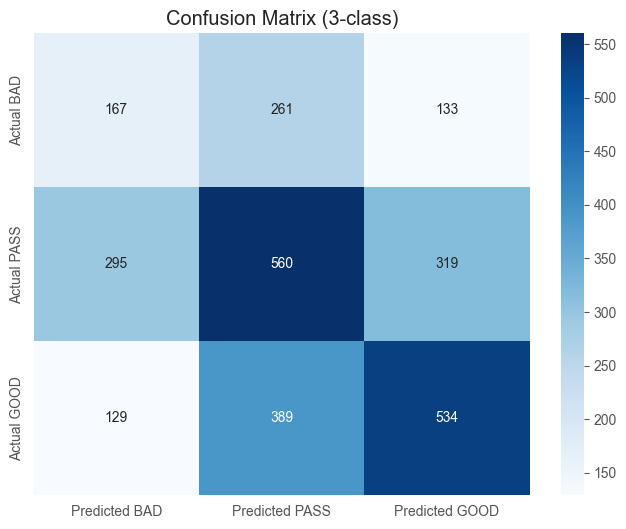

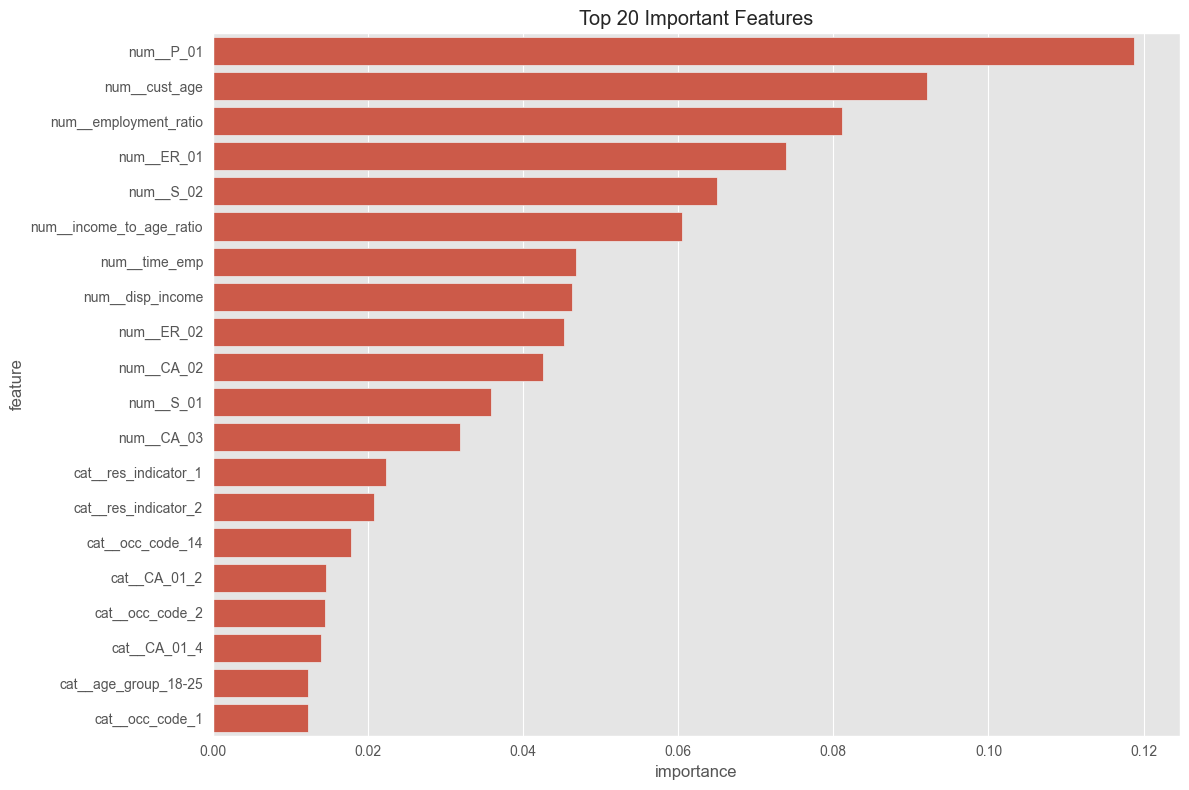

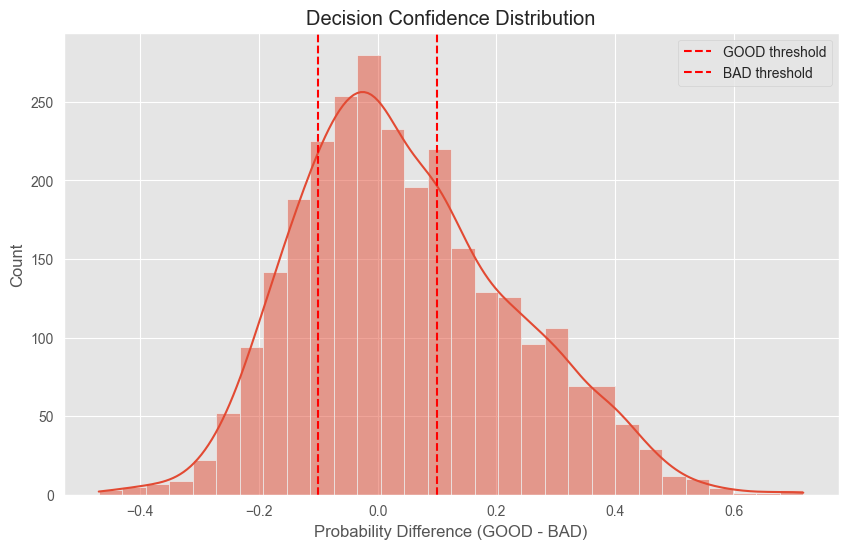


Predicted Class Distribution:
BAD: 21.21%
PASS: 43.42%
GOOD: 35.38%

Final Recommendation:
Based on the evaluation metrics, we recommend deploying the Random Forest model with the following approach:
1. Three-class classification (GOOD, BAD, PASS) where:
   - GOOD if (P(GOOD) - P(BAD)) > 0.10
   - BAD if (P(BAD) - P(GOOD)) > 0.10
   - PASS otherwise (uncertain cases)
2. Current PASS rate: 43.42% of cases need further review

Model performance across all classes:
- Accuracy: 0.4525
- GOOD Precision: 0.5416
- GOOD Recall: 0.5076
- BAD Precision: 0.2826
- BAD Recall: 0.2977

Sample predictions with confidence scores:
      True_Label   P(GOOD)    P(BAD)   P(PASS) Predicted_Class  Confidence
12679       PASS  0.154225  0.241660  0.604115            PASS    0.148036
12825       GOOD  0.442096  0.381236  0.176668            PASS    0.058137
12667       GOOD  0.445112  0.075158  0.479730            GOOD    0.174245
4471        GOOD  0.398246  0.171892  0.429862            GOOD    0.060387
18

In [23]:
if __name__ == "__main__":
    model, results = main()